### Insert the libraries and define the PDC ROP model and execute the program.

In [23]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.legend_handler import HandlerPatch
from scipy.optimize import curve_fit
from SALib.sample import saltelli
from SALib.analyze import sobol

The model was developed by Atashnezhad et al. (2019) as PhD dissertation.
The PDC ROP model is seen at the following.

<p align="left">
  <img  width="450" src="Model1.PNG" >
  <img  width="650" src="Model2.PNG" >
</p>

The PhD dissertation can be found [here](https://github.com/Atashnezhad/PhD_Dissertation) and [here](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=2n95rksAAAAJ&sortby=pubdate&citation_for_view=2n95rksAAAAJ:mB3voiENLucC).


The data was hardcoded in the notebook and more details can be found in the above-provided links.

In [29]:
class Full_bit:
    instances = []
    
    def __init__(self, name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB):
        self.__class__.instances.append(self)
        self.name = name
        self.ROPcons = ROP_constant
        self.Data_WOB = Data_WOB
        self.Data_ROP = Data_ROP
        self.Data_WOB.sort()
        self.Data_ROP.sort()
        self.Db = Db
        self.RPM = RPM
        self.UCS = UCS
        self.NOC = NOC
        self.BR = BR
        self.Dc = Dc
        self.NOB = NOB
             
        self.Ac = math.pi*self.Dc**2 / 4 # cutter face area sq-inch
        self.AB_max = self.Ac*math.sin(math.radians(self.BR))
        self.Re = self.Db/(2*(2**0.5)) # calculate the equivalent radius
        self.Number_of_DataPoints = len(self.Data_WOB)
        self.WOC = [self.Data_WOB[i]/self.NOC for i in range(0,self.Number_of_DataPoints)] # calculate the weight on cutter
        self.A_bit = (math.pi*(self.Db**2))/4 # bit area
        self.AB = [WOC/self.UCS for WOC in self.WOC ] # calculate the cutter beanth area
        self.AB = [self.AB_max if x > self.AB_max else x for x in self.AB] # filter those values that are greater than availabe cutter beanth area
        self.UCSN = self.UCS/5000 # calculate the normalized UCS
        self.V_Cutter_Equivalent = 2*math.pi*self.Re*self.RPM/60 # calculate equivalent velocity
        self.VN = self.V_Cutter_Equivalent/2.1 # normalize the equivalent velocity
        
        
    def A_Front(self, AB, IFA):
        '''A function that takes the cutter beneath the area,
        back rake and IFA and returns the cutter front area.'''
        return AB/math.tan(math.radians(self.BR+IFA))

    def ROP_model(self, AF):
        '''A ROP model (function). A function that takes the number of cutters (NOC),
        bit equivalent radius (Re), cutter front area (AF), cutter back rake (BR),
        interfacial friction angle (IFA), revolutions per minute (RPM), and bit area (A_bit).'''
        return ((2*self.NOC*math.pi*self.Re*AF*self.RPM)/(self.A_bit))*5
        
    def Model_IFA(self, DOC):
        #A model for IFA calculation. it takes DOC,
        #normalized cutter velocity, normalized rock 
        #UCS and cutter back rake and returns the IFA.
        
        #comperhensive IFA model utilizing both fullbit and single cutter data for soft and hard rocks
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 46.873 + (-112.417)/((self.VN)**1 + 3)
        b = 19.506 
        c = 0.3755
        d = 0.109 + 2.753/((self.UCSN**2.227) + 1.954)'''
        
        #hard  rock IFA model utilizing both single cutter and fullbit data
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 57.15 + (-120)/((self.VN)**1 + 3)
        b = 8.35 
        c = 0.55
        d = 0 + 16.74/((self.UCSN**2.5) + 100)'''
        
        #hard  rock IFA model utilizing fullbit data
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 29.82 + (-91.11)/((self.VN)**1 + 3)
        b = 17.02 
        c = 1
        d = 0 + 25.16/((self.UCSN**0.34) + 89.72)'''
        
        #amin thesis full bit IFA
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 57.3 + (-96.44)/((self.VN)**0.753 + 2.22)
        b = 1.886 + (0.48)/((self.VN)**1.6 + 0.79)
        c = 1.58
        d = 0 + (1.07)/((self.UCSN**1.9) + 3)'''
        
        # GH approach 
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 70.66 + (-130.09)/((self.VN)**0.99 + 2.77)
        b = 17.21 + (-85.7)/((self.VN)**1.40 + 0)
        c = 1.24
        d = 6.5 + (-42.73)/((self.UCSN**0.9) + 3.92)'''
        
        #GH approach for Carthage+single cutter+RH data 80 rpm
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 19.18 + (-127.07)/((self.VN)**0.653 + 2.685)
        b = 81.35 + (-26.05)/((self.VN)**1.662 + 53.15)
        c = 0.336
        d = 0.01 + 102.28/((self.UCSN**2.484) + 97.03)'''

        #GH approach for Carthage+single cutter+RH data 80 rpm
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 32.29 + (-161.32)/((self.VN)**0.854 + 16.7)
        b = 34.56 + (-187.32)/((self.VN)**2.43 + 10.12)
        c = 0.462
        d = 0 + 18.04/((self.UCSN**2.26) + 20.68)'''
        
        #GH-IFA (II)
        DOCn = DOC / self.Dc # normalize DOC
        a = 18.90 + (-142.78)/((self.VN)**0.65 + 2.83)
        b = 75.56 + (150)/((self.VN)**2 + 100)
        c = 0.454
        d = 0.323 + (53.61)/((self.UCSN**2.5) + 84.86)
 
        return (a + b / ((DOCn**c) + d))-self.BR
        
    
    def Find_IFA(self, AB, maxvalue):
        #A function that finds the best IFA value that satisfy 
        #both the ROP DOC and developed Model-IFA
        diff1 = 1000000000000000 # initite it with a big value
        Number_of_random_attempts = 10000
        IFA_search = 0

        while diff1 > 0.0001 and IFA_search < maxvalue:

            IFA_search = IFA_search + 0.1
            AF = self.A_Front(AB,IFA_search) #calculate the cutter front area
            ROP = self.ROP_model(AF) # calculate the ROP
            DOC = ROP/(self.RPM*5) # calculate the depth of cut
            IFA = self.Model_IFA(DOC)

            diff2 = abs(IFA_search - IFA)
            
            if diff2 < diff1:
                diff1 = diff2
                self.Best_IFA = IFA_search

        return self.Best_IFA, diff1
    
    def Calculate_ROP(self, AB, maxvalue):
        ''' A function that takes the cutter beneath
        area and returns the ROP estimated'''
        IFA, diff = self.Find_IFA(AB, maxvalue)
        AF = self.A_Front(AB,IFA)
        Estimated_ROP = self.ROPcons * self.ROP_model(AF)
        return Estimated_ROP, IFA, diff
    
    def Calculate_fitness(self):
        
        #===========================================================================================================
        #ROP calculation
        self.ROP_Model_esti_list = []
        self.IFAlist = []
        self.difflist = []
        self.maxvalue = 90 - self.BR
    
        for i in range(0,self.Number_of_DataPoints):
            self.ROP_Model_esti, IFA, diff = self.Calculate_ROP(self.AB[i], self.maxvalue)
            self.ROP_Model_esti_list.append(self.ROP_Model_esti)
            self.difflist.append(diff)
            self.maxvalue = IFA # make sure descending trend for IFA vs DOC
            self.IFAlist.append(IFA)
            
            
    def Calculate_fitness_2(self):
        
        #===========================================================================================================
        #ROP calculation
        self.ROP_Model_esti_list = []
        self.IFAlist = []
        self.difflist = []
        self.maxvalue = 90 - self.BR
    
        for i in range(0,self.Number_of_DataPoints):
            self.ROP_Model_esti, IFA, diff = self.Calculate_ROP(self.AB[i], self.maxvalue)
            self.ROP_Model_esti_list.append(self.ROP_Model_esti)
            self.difflist.append(diff)
            self.maxvalue = IFA # make sure descending trend for IFA vs DOC
            self.IFAlist.append(IFA) 
            
        return self.ROP_Model_esti_list[0]
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
    @classmethod
    def Plot(cls):
        
        fig = plt.figure(figsize=(20,17))
        i = 1
        for instance in cls.instances:
            
            plt.subplot(2, 3, i)
            plt.plot(instance.Data_WOB,instance.Data_ROP,'bo', markersize=4)
            plt.plot(instance.Data_WOB,instance.ROP_Model_esti_list,'r-', label='Model')
            plt.xlim(0,(max(instance.Data_WOB)*1.2))
            plt.ylim(0,(max(instance.Data_ROP)*1.2))
            plt.xlabel('WOB lbf')
            plt.ylabel('ROP ft/hr')
            plt.title('Comparison for {},ROPcons={}, RPM={},\n UCS={}, BR={}, Dc={}, Db={}, NOC={}, NOB={}'\
                      .format(instance.name, instance.ROPcons,instance.RPM,instance.UCS,instance.BR,instance.Dc,instance.Db,instance.NOC,instance.NOB))
            plt.grid(True)
            i += 1

### Insert Data and execute program

In [3]:
#Data for case1_FullBit = error function_SWG_4B_100
Data_WOB = [2300,2420,2660,2910,3180,3410,3660,3940,4170] # insert the WOB data into the list
Data_ROP = [9.9,11,14.7,18.1,22.6,27.2,31.1,36.5,39.4] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
case1_FullBit = Full_bit('SWG_4B_100',0.9, Data_WOB, Data_ROP, 3.75, 100, 21500, 12, 20, 0.5, 4)
case1_FullBit.Calculate_fitness()

#Data for case2_FullBit = error function_SWG_4B_150
Data_WOB = [2150,2300,2560,2810,3060,3290,3540,3820,4070] # insert the WOB data into the list
Data_ROP = [10.2,11.9,15.1,19.6,25.6,31.4,37.7,44.3,50.8] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
case2_FullBit = Full_bit('SWG_4B_150',0.9, Data_WOB, Data_ROP, 3.75, 150, 21500, 12, 20, 0.5, 4)
case2_FullBit.Calculate_fitness()

#Data for case3_FullBit = error function_SWG_4B_200
Data_WOB = [2280,2380,2570,2810,3070,3310,3540,3820,4080] # insert the WOB data into the list
Data_ROP = [11.4,12.5,14.9,18.2,22.9,27.7,34.8,43,50] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
case3_FullBit = Full_bit('SWG_4B_200',0.9, Data_WOB, Data_ROP, 3.75, 200, 21500, 12, 20, 0.5, 4)
case3_FullBit.Calculate_fitness()

#Data for case4_FullBit = error function_BSS_4B_100
Data_WOB = [900,1180,1230,1360,1510,1650,1730,1780] # insert the WOB data into the list
Data_ROP = [24.8,48.9,53.4,54,62,70.8,81.3,84.1] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
case4_FullBit = Full_bit('BSS_4B_100',0.9, Data_WOB, Data_ROP, 3.75, 100, 7100, 12, 20, 0.5, 4)
case4_FullBit.Calculate_fitness()

#Data for case5_FullBit = error function_BSS_4B_150
Data_WOB = [970,1090,1110,1300,1520,1720,1770,1960] # insert the WOB data into the list
Data_ROP = [40.8,61.9,64.5,71.7,91.5,102.9,106.9,127.7] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
case5_FullBit = Full_bit('BSS_4B_150',0.9, Data_WOB, Data_ROP, 3.75, 150, 7100, 12, 20, 0.5, 4)
case5_FullBit.Calculate_fitness()

#Data for case6_FullBit = error function_BSS_4B_200
Data_WOB = [850,960,1150,1210,1270,1340,1570,1800] # insert the WOB data into the list
Data_ROP = [30.5,59.5,84.8,87.8,96.5,96.6,120.9,136] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
case6_FullBit = Full_bit('BSS_4B_200',0.9, Data_WOB, Data_ROP, 3.75, 200, 7100, 12, 20, 0.5, 4)
case6_FullBit.Calculate_fitness()

### Plot all instances in class

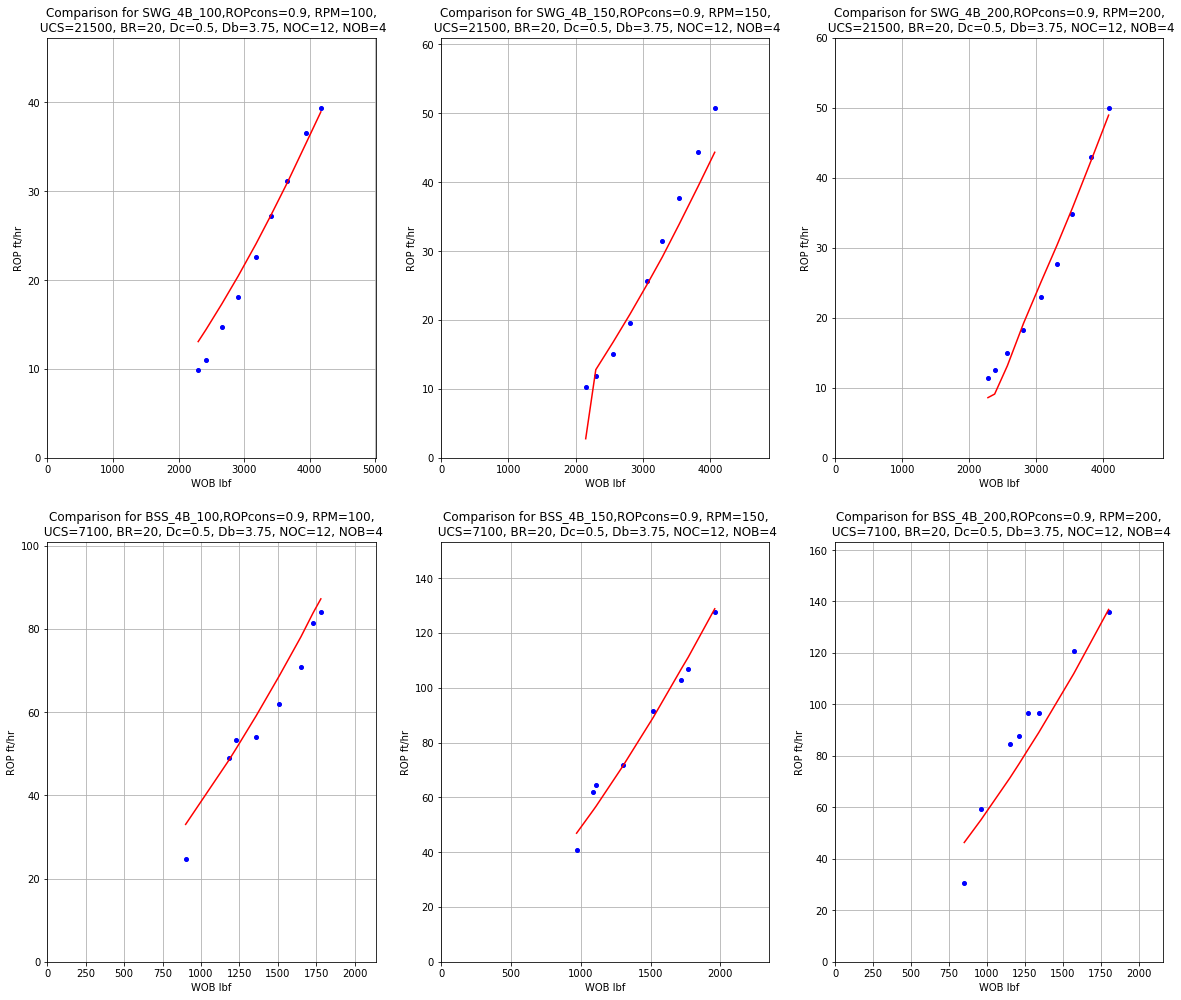

In [4]:
Full_bit.Plot()

## Sensitivity Analysis

Parameters Interaction Visualization

In [35]:
class Full_bit_2:
    instances = []
    
    def __init__(self, name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB):
        self.__class__.instances.append(self)
        self.name = name
        self.ROPcons = ROP_constant
        self.Data_WOB = Data_WOB
        self.Data_ROP = Data_ROP
#         self.Data_WOB.sort()
#         self.Data_ROP.sort()
        self.Db = Db
        self.RPM = RPM
        self.UCS = UCS
        self.NOC = NOC
        self.BR = BR
        self.Dc = Dc
        self.NOB = NOB
             
        self.Ac = math.pi*self.Dc**2 / 4 # cutter face area sq-inch
        self.AB_max = self.Ac*math.sin(math.radians(self.BR))
        self.Re = self.Db/(2*(2**0.5)) # calculate the equivalent radius
        self.Number_of_DataPoints = 1
        self.WOC = [self.Data_WOB[i]/self.NOC for i in range(0,self.Number_of_DataPoints)] # calculate the weight on cutter
        self.A_bit = (math.pi*(self.Db**2))/4 # bit area
        self.AB = [WOC/self.UCS for WOC in self.WOC ] # calculate the cutter beanth area
        self.AB = [self.AB_max if x > self.AB_max else x for x in self.AB] # filter those values that are greater than availabe cutter beanth area
        self.UCSN = self.UCS/5000 # calculate the normalized UCS
        self.V_Cutter_Equivalent = 2*math.pi*self.Re*self.RPM/60 # calculate equivalent velocity
        self.VN = self.V_Cutter_Equivalent/2.1 # normalize the equivalent velocity
        
        
    def A_Front(self, AB, IFA):
        '''A function that takes the cutter beneath the area,
        back rake and IFA and returns the cutter front area.'''
        return AB/math.tan(math.radians(self.BR+IFA))

    def ROP_model(self, AF):
        '''A ROP model (function). A function that takes the number of cutters (NOC),
        bit equivalent radius (Re), cutter front area (AF), cutter back rake (BR),
        interfacial friction angle (IFA), revolutions per minute (RPM), and bit area (A_bit).'''
        return ((2*self.NOC*math.pi*self.Re*AF*self.RPM)/(self.A_bit))*5
        
    def Model_IFA(self, DOC):
        #A model for IFA calculation. it takes DOC,
        #normalized cutter velocity, normalized rock 
        #UCS and cutter back rake and returns the IFA.
        
        #comperhensive IFA model utilizing both fullbit and single cutter data for soft and hard rocks
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 46.873 + (-112.417)/((self.VN)**1 + 3)
        b = 19.506 
        c = 0.3755
        d = 0.109 + 2.753/((self.UCSN**2.227) + 1.954)'''
        
        #hard  rock IFA model utilizing both single cutter and fullbit data
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 57.15 + (-120)/((self.VN)**1 + 3)
        b = 8.35 
        c = 0.55
        d = 0 + 16.74/((self.UCSN**2.5) + 100)'''
        
        #hard  rock IFA model utilizing fullbit data
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 29.82 + (-91.11)/((self.VN)**1 + 3)
        b = 17.02 
        c = 1
        d = 0 + 25.16/((self.UCSN**0.34) + 89.72)'''
        
        #amin thesis full bit IFA
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 57.3 + (-96.44)/((self.VN)**0.753 + 2.22)
        b = 1.886 + (0.48)/((self.VN)**1.6 + 0.79)
        c = 1.58
        d = 0 + (1.07)/((self.UCSN**1.9) + 3)'''
        
        # GH approach 
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 70.66 + (-130.09)/((self.VN)**0.99 + 2.77)
        b = 17.21 + (-85.7)/((self.VN)**1.40 + 0)
        c = 1.24
        d = 6.5 + (-42.73)/((self.UCSN**0.9) + 3.92)'''
        
        #GH approach for Carthage+single cutter+RH data 80 rpm
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 19.18 + (-127.07)/((self.VN)**0.653 + 2.685)
        b = 81.35 + (-26.05)/((self.VN)**1.662 + 53.15)
        c = 0.336
        d = 0.01 + 102.28/((self.UCSN**2.484) + 97.03)'''

        #GH approach for Carthage+single cutter+RH data 80 rpm
        '''DOCn = DOC / self.Dc # normalize DOC
        a = 32.29 + (-161.32)/((self.VN)**0.854 + 16.7)
        b = 34.56 + (-187.32)/((self.VN)**2.43 + 10.12)
        c = 0.462
        d = 0 + 18.04/((self.UCSN**2.26) + 20.68)'''
        
        #GH-IFA (II)
        DOCn = DOC / self.Dc # normalize DOC
        a = 18.90 + (-142.78)/((self.VN)**0.65 + 2.83)
        b = 75.56 + (150)/((self.VN)**2 + 100)
        c = 0.454
        d = 0.323 + (53.61)/((self.UCSN**2.5) + 84.86)
 
        return (a + b / ((DOCn**c) + d))-self.BR
        
    
    def Find_IFA(self, AB, maxvalue):
        #A function that finds the best IFA value that satisfy 
        #both the ROP DOC and developed Model-IFA
        diff1 = 1000000000000000 # initite it with a big value
        Number_of_random_attempts = 10000
        IFA_search = 0

        while diff1 > 0.0001 and IFA_search < maxvalue:

            IFA_search = IFA_search + 0.1
            AF = self.A_Front(AB,IFA_search) #calculate the cutter front area
            ROP = self.ROP_model(AF) # calculate the ROP
            DOC = ROP/(self.RPM*5) # calculate the depth of cut
            IFA = self.Model_IFA(DOC)

            diff2 = abs(IFA_search - IFA)
            
            if diff2 < diff1:
                diff1 = diff2
                self.Best_IFA = IFA_search

        return self.Best_IFA, diff1
    
    def Calculate_ROP(self, AB, maxvalue):
        ''' A function that takes the cutter beneath
        area and returns the ROP estimated'''
        IFA, diff = self.Find_IFA(AB, maxvalue)
        AF = self.A_Front(AB,IFA)
        Estimated_ROP = self.ROPcons * self.ROP_model(AF)
        return Estimated_ROP, IFA, diff
    
    def Calculate_fitness(self):
        
        #===========================================================================================================
        #ROP calculation
        self.ROP_Model_esti_list = []
        self.IFAlist = []
        self.difflist = []
        self.maxvalue = 90 - self.BR
    
        for i in range(0,self.Number_of_DataPoints):
            self.ROP_Model_esti, IFA, diff = self.Calculate_ROP(self.AB[i], self.maxvalue)
            self.ROP_Model_esti_list.append(self.ROP_Model_esti)
            self.difflist.append(diff)
            self.maxvalue = IFA # make sure descending trend for IFA vs DOC
            self.IFAlist.append(IFA)
            
            
    def Calculate_fitness_2(self):
        
        #===========================================================================================================
        #ROP calculation
        self.ROP_Model_esti_list = []
        self.IFAlist = []
        self.difflist = []
        self.maxvalue = 90 - self.BR
    
        for i in range(0,self.Number_of_DataPoints):
            self.ROP_Model_esti, IFA, diff = self.Calculate_ROP(self.AB[i], self.maxvalue)
            self.ROP_Model_esti_list.append(self.ROP_Model_esti)
            self.difflist.append(diff)
            self.maxvalue = IFA # make sure descending trend for IFA vs DOC
            self.IFAlist.append(IFA) 
            
        return self.ROP_Model_esti_list[0]
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
    @classmethod
    def Plot(cls):
        
        fig = plt.figure(figsize=(20,17))
        i = 1
        for instance in cls.instances:
            
            plt.subplot(2, 3, i)
            plt.plot(instance.Data_WOB,instance.Data_ROP,'bo', markersize=4)
            plt.plot(instance.Data_WOB,instance.ROP_Model_esti_list,'r-', label='Model')
            plt.xlim(0,(max(instance.Data_WOB)*1.2))
            plt.ylim(0,(max(instance.Data_ROP)*1.2))
            plt.xlabel('WOB lbf')
            plt.ylabel('ROP ft/hr')
            plt.title('Comparison for {},ROPcons={}, RPM={},\n UCS={}, BR={}, Dc={}, Db={}, NOC={}, NOB={}'\
                      .format(instance.name, instance.ROPcons,instance.RPM,instance.UCS,instance.BR,instance.Dc,instance.Db,instance.NOC,instance.NOB))
            plt.grid(True)
            i += 1

In [36]:
Data_WOB = [5000] # insert the WOB data into the list
Data_ROP = [30.5] # insert the ROP data into the list
#'(name, ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)'
new_data_FullBit = Full_bit_2('new_data',0.9, Data_WOB, Data_ROP, 3.75, 200, 25000, 12, 20, 0.5, 4)
new_data_FullBit.Calculate_fitness_2()

23.69469870695222

In [37]:
def Atashnezhad_etal_ROP(ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB):
    new_data_FullBit = Full_bit_2('new_data',ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)
    rop = new_data_FullBit.Calculate_fitness_2()
    return rop

In [38]:
problem = {
    'num_vars': 10,
    'names': ['ROP_constant', 'WOB', 'Data_ROP', 'Db', 'RPM', 'UCS', 'NOC', 'BR', 'Dc', 'NOB'],
    'bounds': [[0.4,1.2],
              [1000,9000],
              [1,4],
              [3,12.25],
              [30,350],
              [3500,15000],
              [8,30],
              [8,30],
              [0.3,0.8],
              [4,12],
              ]}

In [39]:
def evaluate_model(row):
    ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB = row
    ROP = Atashnezhad_etal_ROP(ROP_constant, Data_WOB, Data_ROP, Db, RPM, UCS, NOC, BR, Dc, NOB)
    return ROP

In [40]:
param_values = saltelli.sample(problem, 1024)

Y = np.zeros([param_values.shape[0]])
for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)

IndexError: invalid index to scalar variable.

In [ ]:
Si = sobol.analyze(problem, Y, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

In [ ]:
import Interaction_Viz

In [ ]:
Interaction_Viz.Apply(Si, problem, threshold=0.0005)